In [558]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pygraphviz as pgv

from IPython.display import Image

%matplotlib notebook

In [568]:
class PertGraph:
    def __init__(self, data):
        self.graph = nx.DiGraph()
        for activity in data.to_records(index=True):
            edge = (activity['nodo_inicial'], activity['nodo_final'] )
            self.graph.add_edge(*edge)
            self.graph.edges[edge]['nombre'] = activity['index']
            self.graph.edges[edge]['duracion'] = activity['duracion']
        self.calcula_pert()
            
    def calcula_pert(self):
        lista_de_nodos = list(self.graph)
        
        # [0] sirve para inicializar el tiempo temprano del nodo inicial correctamente
        # [self.graph.nodes[lista_de_nodos[-1]]['temprano']] sirve para inicializar el tiempo tardío del nodo final correctamente con el valor del tiempo temprano
        
        for nodo in lista_de_nodos:
           self.graph.nodes[nodo]['temprano'] = max([0]+
                                                    [(self.graph.nodes[inicial]['temprano'] + attributes['duracion']) 
                                                          for (inicial, final, attributes) in self.graph.in_edges(nodo, data=True) ] )
        for nodo in lista_de_nodos[::-1]:
           self.graph.nodes[nodo]['tardio'] = min([self.graph.nodes[lista_de_nodos[-1]]['temprano']]+
                                                  [ (self.graph.nodes[final]['tardio'] - attributes['duracion'])
                                                    for (inicial, final, attributes) in self.graph.out_edges(nodo, data=True) ] )
        
        for (nodo_inicial, nodo_final) in self.graph.edges:
            self.graph.edges[nodo_inicial, nodo_final]['H_total'] = self.graph.nodes[nodo_final]['tardio'] - self.graph.edges[nodo_inicial, nodo_final]['duracion'] - self.graph.nodes[nodo_inicial]['temprano']

    def duracion(self):
        return  nx.dag_longest_path_length(self.graph, weight='duracion') 
    
    def camino_critico(self):
        return {'Actividades': [(attributes['nombre']) for (nodo_inicial, nodo_final, attributes) in pert.graph.edges(data=True) if attributes['H_total']==0],
                'Nodos': nx.dag_longest_path(self.graph, weight='duracion')}
    
    def tiempos(self):
        return pd.DataFrame(dict(pert.graph.nodes(data=True)))
    
    def holguras(self):
        holguras = pd.DataFrame([{'H_total': attributes['H_total'], 'nombre': attributes['nombre']}
                                             for (inicial, final, attributes) in self.graph.edges(data=True)]).set_index('nombre')
        return holguras
    def draw(self):
        nx.draw(self.graph,with_labels=True)
        
    def Zaderenko(self):
        a = pd.DataFrame(data=nx.adjacency_matrix(pert.graph, weight='duracion').todense(),
                         index=  pert.graph.nodes(),
                         columns= pert.graph.nodes()
                        ).replace(0, np.nan)
        T = pert.tiempos()
        a['temprano'] = T.loc['temprano',:]
        a = a.append(T.loc['tardio',:]).fillna('')
        return a
    
    def write_dot(self, filename, size=None, orientation='landscape', rankdir='LR', ordering='out',
                  ranksep=1, nodesep=1, rotate=0, **kwargs):
        dot_graph = pgv.AGraph(size = size,
                               orientation = orientation,
                               rankdir = rankdir,
                               ranksep = ranksep,
                               nodesep = nodesep,
                               rotate=rotate,
                               directed=True,
                               **kwargs) 
        dot_graph.node_attr['shape']='Mrecord'
        dot_graph.add_edges_from(self.graph.edges)
        
        for nodo in dot_graph.nodes():
            current_node = dot_graph.get_node(nodo)
            node_number = int(nodo)
            current_node.attr['label']=(f"{node_number} | {{ "
                                        f"<early> {self.graph.nodes[node_number]['temprano']} | "
                                        f"<last>  {self.graph.nodes[node_number]['tardio']} }}")
        
        for origin, destination in dot_graph.edges_iter():
            current_edge = dot_graph.get_edge(origin, destination)
            current_edge_tuple_of_ints = (int(origin), int(destination))
            current_edge.attr['headport'] = 'early'
            current_edge.attr['tailport'] = 'last'
            current_edge.attr['label'] =(f"{self.graph.edges[current_edge_tuple_of_ints]['nombre']}"
                                         f"({self.graph.edges[current_edge_tuple_of_ints]['duracion']})")
                
            if self.graph.edges[current_edge_tuple_of_ints]['H_total'] == 0:
                current_edge.attr['color'] = 'red:red'
                current_edge.attr['style'] = 'bold'
            
            if self.graph.edges[current_edge_tuple_of_ints]['nombre'][0] == 'f':
                current_edge.attr['style'] = 'dashed'
                                  
        self.dot_graph = dot_graph
        dot_graph.draw(filename, prog='dot')

In [569]:
datos_pert = pd.DataFrame({ 'A':  (1, 2, 3),
                            'B':  (1, 3, 2),
                            'C':  (2, 3, 7),
                            'D':  (2, 4, 5),
                            'E':  (3, 5, 6),
                            'F':  (3, 6, 7),
                            'G':  (4, 5, 4),
                            'H':  (5, 6, 4),
                            'f1': (1, 5, 0),
                            'f2': (2, 5, 0),
                          },
                          index=['nodo_inicial','nodo_final','duracion']).T

In [570]:
pert = PertGraph(datos_pert)

In [ ]:
filename='pert_dot.png'
pert.write_dot(filename=filename, orientation='portrait', rotate=0)

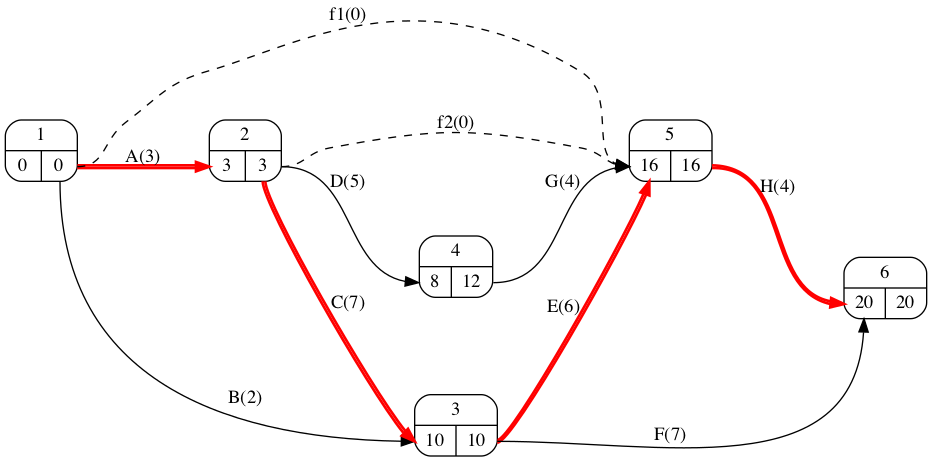

In [579]:
Image(filename)

In [580]:
pert.Zaderenko()

,1,2,3,4,5,6,temprano
1,,3,2,,,,0
2,,,7,5,,,3
3,,,,,6,7,10
4,,,,,4,,8
5,,,,,,4,16
6,,,,,,,20
tardio,0,3,10,12,16,20,


In [581]:
pert.tiempos()

,1,2,3,4,5,6
tardio,0,3,10,12,16,20
temprano,0,3,10,8,16,20


In [582]:
pert.duracion()

20

In [583]:
pert.holguras()

,H_total
nombre,
A,0
B,8
f1,16
C,0
D,4
f2,13
E,0
F,3
G,4


In [576]:
pert.camino_critico()

{'Actividades': ['A', 'C', 'E', 'H'], 'Nodos': [1, 2, 3, 5, 6]}